Ref:

https://www.kaggle.com/code/pmigdal/transfer-learning-with-resnet-50-in-pytorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
import math
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from time import time
from skimage import measure
from torchvision import datasets, models, transforms
from skimage.color import gray2rgb
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

# Data

In [ ]:
img_size = 224 #512x512
batch_size = 8

In [ ]:
#define image and mask paths
TEST_IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/test/images/'
TEST_MASK_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/test/labels/'

TRAIN_IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/train/images/'
TRAIN_MASK_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/train/labels/'


SEGMENTED_TEST_IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Segmented_Microplastic_SEM_Images/test/'
SEGMENTED_TRAIN_IMAGE_PATH = '/content/drive/MyDrive/Colab Notebooks/SEM/Segmented_Microplastic_SEM_Images/train/'


TRAINED_MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/SEM/Classifier_Trained_model/"

In [ ]:
#read csv
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_test.csv")
bead = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_bead_train_all.csv')
fibre_1crop = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_fibre_1crop_train_all.csv')
fragment_1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_fragment_1_train_all.csv')
fragment_2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEM/Microplastics_SEM_Images/counts_fragment_2_train_all.csv')

bead.head()

,name,count,class
0,Dove_men_acrylates_copolymer_microbeads_002.png,1,bead
1,Dove_men_acrylates_copolymer_microbeads_004.png,1,bead
2,Dove_men_acrylates_copolymer_microbeads_006.png,1,bead
3,Dove_men_acrylates_copolymer_microbeads_007.png,2,bead
4,Dove_men_acrylates_copolymer_microbeads_016.png,1,bead


In [ ]:
#concat dataframes
frames = [bead, fibre_1crop, fragment_1,fragment_2]
train_df = pd.concat(frames)
train_df = train_df.reset_index(drop=True)
print('Total Train Images: ', len(train_df))
print('Total Test Images: ', len(test_df))

Total Train Images:  624
Total Test Images:  52


In [ ]:
#encode the class to numerical values
classes=train_df["class"].unique()
classes = list(classes)

class_encoded = dict(zip(classes, range(0,3)))
class_encoded

{'bead': 0, 'fibre': 1, 'fragment': 2}

In [ ]:
train_df['class'] = train_df['class'].map(class_encoded, na_action='ignore')

In [ ]:
test_df['class'] = test_df['class'].map(class_encoded, na_action='ignore')

In [ ]:
test_df.head()

,name,count,class
0,Dove_men_acrylates_copolymer_microbeads_003.png,2,0
1,Dove_men_acrylates_copolymer_microbeads_008.png,1,0
2,Dove_men_acrylates_copolymer_microbeads_009.png,1,0
3,Dove_men_acrylates_copolymer_microbeads_012.png,2,0
4,Dove_men_acrylates_copolymer_microbeads_015.png,2,0


# Dataloader Segmented Images

In [ ]:
class MP_SEM_Image_Dataset(Dataset):
    def __init__(self,data_type,dataset_df,transform=None):
        self.data_type = data_type
        self.dataset_df = dataset_df
        self.transform = transform

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self,index):
        #get shape and count of a file
        shape = self.dataset_df['class'][index]
        count = self.dataset_df['count'][index]


        if self.data_type == "train":
            img_path = os.path.join(SEGMENTED_TRAIN_IMAGE_PATH,self.dataset_df['name'][index])

        else: #test
            img_path = os.path.join(SEGMENTED_TEST_IMAGE_PATH,self.dataset_df['name'][index])


        img = Image.open(img_path)
        img = gray2rgb(img)
        if self.transform:
            img = self.transform(img)


        return img,shape,count

In [ ]:
#data transformation
data_transform= transforms.Compose([transforms.ToPILImage() , transforms.Resize((img_size, img_size)),
                                                  transforms.ToTensor()])


In [ ]:
train_dataset = MP_SEM_Image_Dataset(data_type = "train",dataset_df = train_df, transform = data_transform)
test_dataset = MP_SEM_Image_Dataset(data_type = "test",dataset_df = test_df, transform = data_transform)


#train loader
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

In [ ]:
#check if dataloader is working
dataiter = iter(test_dataloader)
data = next(dataiter)

In [ ]:
def visualize(image):
  fontsize = 10
  plt.figure()
  plt.imshow(image,cmap='Greys_r', interpolation='nearest')
  plt.title('Segmented Image', fontsize=fontsize)
  plt.show()

In [ ]:
data[0].shape

torch.Size([8, 3, 224, 224])

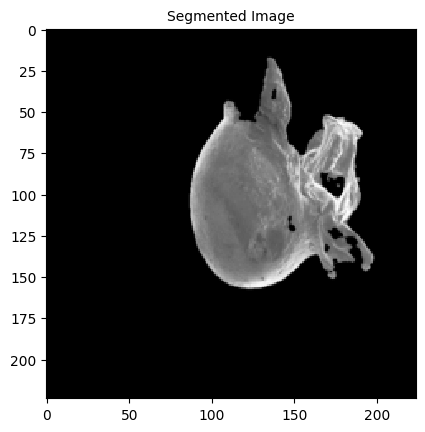

In [ ]:
visualize(data[0][1][0])

# Train and Test Functions

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val*n
        self.count+=n
        self.avg = self.sum/self.count

In [ ]:
def train(train_loader, model, criterion, optimizer):
    avg_meters = {'loss':AverageMeter(),'acc':AverageMeter()}
    model.train()

    for X, Y,_ in train_loader:
        #image
        X= X.cuda()
        #shape
        Y = Y.cuda()

        #predict
        Y_pred = model(X)
        #calculate loss
        loss = criterion(Y_pred,Y)


        optimizer.zero_grad()
        #loss
        loss.backward()
        optimizer.step()

        #acc
        _, predicted = torch.max(Y_pred.data, 1)
        acc = torch.sum(predicted==Y).item()/X.size(0)


        #update metrics
        avg_meters['loss'].update(loss.item(), X.size(0))
        avg_meters['acc'].update(acc, X.size(0))


    return OrderedDict([('loss', avg_meters['loss'].avg),('acc', avg_meters['acc'].avg)])

In [ ]:
def test(val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),'acc': AverageMeter()}

    #  evaluate mode
    model.eval()

    with torch.no_grad():

        for X, Y, _ in val_loader:
            X = X.cuda()
            Y = Y.cuda()

            Y_pred = model(X)
            loss = criterion(Y_pred, Y)

            #acc
            _, predicted = torch.max(Y_pred.data, 1)
            acc = torch.sum(predicted==Y).item()/X.size(0)


            #update metrics
            avg_meters['loss'].update(loss.item(), X.size(0))
            avg_meters['acc'].update(acc, X.size(0))



    return OrderedDict([('loss', avg_meters['loss'].avg),('acc', avg_meters['acc'].avg)])

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Model1 - Resnet18 in Segmented data

In [ ]:
model = models.resnet18(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False
#modify output layer
model.fc = nn.Sequential(
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 3)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model = model.cuda()
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
learning_rate = 1e-4
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = learning_rate)


In [ ]:
model = model.cuda()

In [ ]:
model_name = "Model1_Resnet18"
params = filter(lambda p: p.requires_grad, model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)


log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('acc', []),
    ('test_loss', []),
    ('test_acc', []),
])

start_time = time()
for epoch in range(num_epochs):
    print('Epoch %d : ' % (epoch))

    # train
    train_log = train(train_dataloader, model, criterion, optimizer)

    # evaluate on test set
    test_log = test(test_dataloader, model, criterion)

    scheduler.step()

    print('loss %.4f - acc %.4f  - test_loss %.4f - test_acc %.4f'
          % (train_log['loss'], train_log['acc'],test_log['loss'], test_log['acc']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['acc'].append(train_log['acc'])
    log['test_loss'].append(test_log['loss'])
    log['test_acc'].append(test_log['acc'])

    #save log to csv
    pd.DataFrame(log).to_csv(TRAINED_MODEL_PATH+model_name+'_log.csv', index=False)
    torch.cuda.empty_cache()


end_time = time()
total_time = end_time - start_time
print("total time: "+ str(total_time))

Epoch 0 : 
loss 0.8844 - acc 0.5913  - test_loss 0.6094 - test_acc 0.7885
Epoch 1 : 
loss 0.4591 - acc 0.8622  - test_loss 0.2169 - test_acc 0.9615
Epoch 2 : 
loss 0.2307 - acc 0.9535  - test_loss 0.1741 - test_acc 0.9423
Epoch 3 : 
loss 0.2066 - acc 0.9391  - test_loss 0.1155 - test_acc 0.9615
Epoch 4 : 
loss 0.1420 - acc 0.9679  - test_loss 0.0946 - test_acc 0.9615
Epoch 5 : 
loss 0.1098 - acc 0.9679  - test_loss 0.1437 - test_acc 0.9615
Epoch 6 : 
loss 0.1155 - acc 0.9663  - test_loss 0.1277 - test_acc 0.9615
Epoch 7 : 
loss 0.1108 - acc 0.9599  - test_loss 0.0948 - test_acc 0.9615
Epoch 8 : 
loss 0.1165 - acc 0.9583  - test_loss 0.1072 - test_acc 0.9615
Epoch 9 : 
loss 0.1050 - acc 0.9647  - test_loss 0.0959 - test_acc 0.9615
Epoch 10 : 
loss 0.0988 - acc 0.9647  - test_loss 0.1216 - test_acc 0.9615
Epoch 11 : 
loss 0.1668 - acc 0.9391  - test_loss 0.0854 - test_acc 0.9615
Epoch 12 : 
loss 0.1050 - acc 0.9647  - test_loss 0.0889 - test_acc 0.9615
Epoch 13 : 
loss 0.0845 - acc 0.977

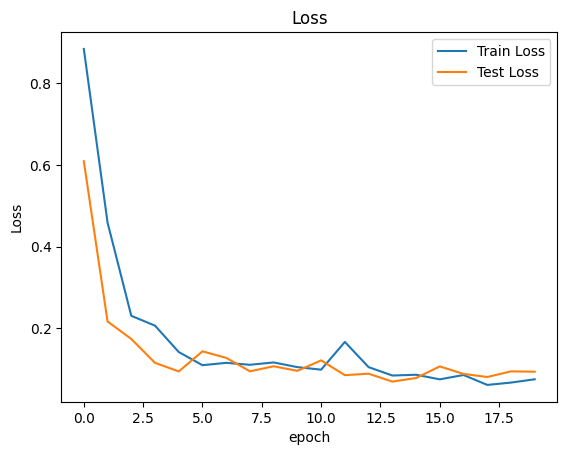

In [ ]:
#plot of loss of the models
plt.plot(log['loss'],label='Train Loss')
plt.plot(log['test_loss'],label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


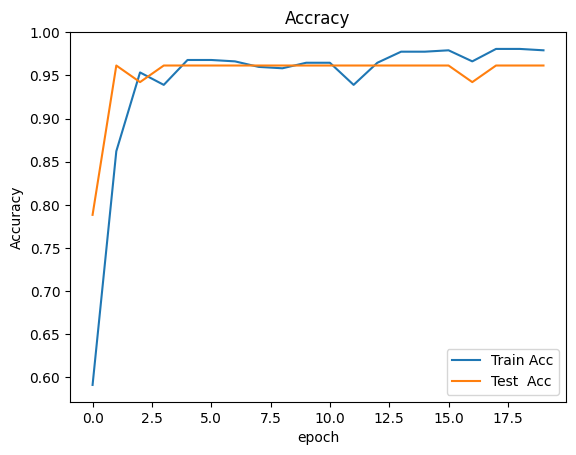

In [ ]:
#plot of accuracies of the models
plt.plot(log['acc'],label='Train Acc')
plt.plot(log['test_acc'],label='Test  Acc')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accracy')
plt.legend()
plt.show()


In [ ]:
#copy model1 metrics
log_model1 = log.copy()

In [ ]:
#save the model
TRAINED_FILE =TRAINED_MODEL_PATH + model_name +".pth"
torch.save(model.state_dict(), TRAINED_FILE)

Test model to get other metrics

In [ ]:
model = models.resnet18(pretrained=False).to(device)

model.fc = nn.Sequential(
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 3)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
#loading the saved model
model.load_state_dict(torch.load(TRAINED_FILE))
trained_model = model.to("cuda")
trained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for i,(x,y,_) in enumerate(test_dataloader):
  y = np.array(y)
  y_true = np.concatenate((y_true,y))
  outputs = model(x.cuda())
  _, preds = torch.max(outputs, 1)
  preds = np.array(preds.cpu())
  y_pred = np.concatenate((y_pred,preds))

In [ ]:
target_names = ['bead', 'fiber', 'fragment']
print(classification_report(y_true, y_pred, target_names=target_names,digits=4))

              precision    recall  f1-score   support

        bead     1.0000    0.8182    0.9000        11
       fiber     1.0000    1.0000    1.0000        21
    fragment     0.9091    1.0000    0.9524        20

    accuracy                         0.9615        52
   macro avg     0.9697    0.9394    0.9508        52
weighted avg     0.9650    0.9615    0.9605        52



# Dataloader Original Images

Unsegmented images

In [ ]:
class MP_SEM_Image_Dataset_Original(Dataset):
    def __init__(self,data_type,dataset_df,transform=None):
        self.data_type = data_type
        self.dataset_df = dataset_df
        self.transform = transform

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self,index):
        #get shape and count of a file
        shape = self.dataset_df['class'][index]
        count = self.dataset_df['count'][index]


        if self.data_type == "train":
            img_path = os.path.join(TRAIN_IMAGE_PATH,self.dataset_df['name'][index])

        else: #test
            img_path = os.path.join(TEST_IMAGE_PATH,self.dataset_df['name'][index])


        img = Image.open(img_path).convert('RGB')
        #img = gray2rgb(img)

        if self.transform:
            img = self.transform(img)
        #print(img.shape)
        return img,shape,count

In [ ]:
#data transformation
data_transforms= transforms.Compose([#transforms.ToPILImage() ,
                                    transforms.Resize((img_size, img_size)),
                                                  transforms.ToTensor()])


In [ ]:
train_dataset = MP_SEM_Image_Dataset_Original(data_type = "train",dataset_df = train_df, transform = data_transforms)
test_dataset = MP_SEM_Image_Dataset_Original(data_type = "test",dataset_df = test_df, transform = data_transforms)

#train loader
train_dataloader_orig = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader_orig = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)

In [ ]:
#check if dataloader is working
dataiter = iter(test_dataloader_orig)
data = next(dataiter)

In [ ]:
data[0].shape

torch.Size([8, 3, 224, 224])

# Model2 - Resnet18 in Original Images

In [ ]:
model = models.resnet18(pretrained=True).to(device)

for param in model.parameters():
    param.requires_grad = False
#modify 1st layer
#model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,bias=False)
#modify output layer
model.fc = nn.Sequential(
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 3)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
learning_rate = 1e-4
num_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = learning_rate)
#optimizer = optim.Adam(model.parameters(),)

In [ ]:
model = model.cuda()

In [ ]:
model_name = "Model2_Resnet18"
params = filter(lambda p: p.requires_grad, model.parameters())
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)


log = OrderedDict([
    ('epoch', []),
    ('loss', []),
    ('acc', []),
    ('test_loss', []),
    ('test_acc', []),
])

start_time = time()
for epoch in range(num_epochs):
    print('Epoch %d : ' % (epoch))

    # train
    train_log = train(train_dataloader_orig, model, criterion, optimizer)

    # evaluate on test set
    test_log = test(test_dataloader_orig, model, criterion)

    scheduler.step()

    print('loss %.4f - acc %.4f  - test_loss %.4f - test_acc %.4f'
          % (train_log['loss'], train_log['acc'],test_log['loss'], test_log['acc']))

    log['epoch'].append(epoch)
    log['loss'].append(train_log['loss'])
    log['acc'].append(train_log['acc'])
    log['test_loss'].append(test_log['loss'])
    log['test_acc'].append(test_log['acc'])

    #save log to csv
    pd.DataFrame(log).to_csv(TRAINED_MODEL_PATH+model_name+'_log.csv', index=False)
    torch.cuda.empty_cache()


end_time = time()
total_time = end_time - start_time
print("total time: "+ str(total_time))

Epoch 0 : 
loss 0.9105 - acc 0.5994  - test_loss 0.7149 - test_acc 0.7308
Epoch 1 : 
loss 0.4830 - acc 0.8654  - test_loss 0.2103 - test_acc 0.9615
Epoch 2 : 
loss 0.2462 - acc 0.9423  - test_loss 0.0818 - test_acc 1.0000
Epoch 3 : 
loss 0.1744 - acc 0.9423  - test_loss 0.0614 - test_acc 1.0000
Epoch 4 : 
loss 0.1330 - acc 0.9583  - test_loss 0.0369 - test_acc 0.9808
Epoch 5 : 
loss 0.1289 - acc 0.9583  - test_loss 0.0250 - test_acc 1.0000
Epoch 6 : 
loss 0.1163 - acc 0.9679  - test_loss 0.0178 - test_acc 1.0000
Epoch 7 : 
loss 0.1006 - acc 0.9679  - test_loss 0.0202 - test_acc 1.0000
Epoch 8 : 
loss 0.0829 - acc 0.9776  - test_loss 0.0123 - test_acc 1.0000
Epoch 9 : 
loss 0.0890 - acc 0.9712  - test_loss 0.0118 - test_acc 1.0000
Epoch 10 : 
loss 0.0540 - acc 0.9888  - test_loss 0.0129 - test_acc 1.0000
Epoch 11 : 
loss 0.0898 - acc 0.9776  - test_loss 0.0141 - test_acc 1.0000
Epoch 12 : 
loss 0.0868 - acc 0.9744  - test_loss 0.0079 - test_acc 1.0000
Epoch 13 : 
loss 0.0598 - acc 0.980

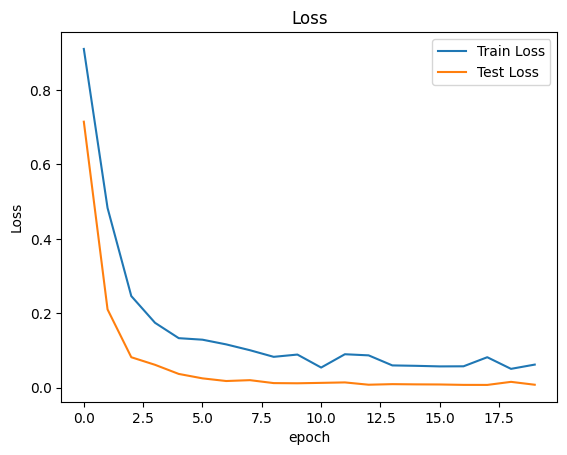

In [ ]:
#plot of loss of the models
plt.plot(log['loss'],label='Train Loss')
plt.plot(log['test_loss'],label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


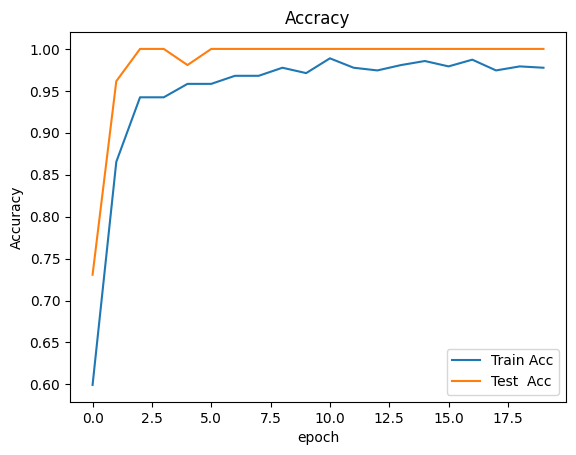

In [ ]:
#plot of accuracies of the models
plt.plot(log['acc'],label='Train Acc')
plt.plot(log['test_acc'],label='Test  Acc')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accracy')
plt.legend()
plt.show()


In [ ]:
#copy model1 metrics
log_model2 = log.copy()

In [ ]:
#save the model
TRAINED_FILE =TRAINED_MODEL_PATH + model_name +".pth"
torch.save(model.state_dict(), TRAINED_FILE)

Test model to get other metrics

In [ ]:
model = models.resnet18(pretrained=False).to(device)

model.fc = nn.Sequential(
               nn.Linear(512, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 256),
               nn.ReLU(inplace=True),
               nn.Dropout(.3),
               nn.Linear(256, 3)).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
#loading the saved model
model.load_state_dict(torch.load(TRAINED_FILE))
trained_model = model.to("cuda")
trained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for i,(x,y,_) in enumerate(test_dataloader_orig):
  y = np.array(y)
  y_true = np.concatenate((y_true,y))
  outputs = model(x.cuda())
  _, preds = torch.max(outputs, 1)
  preds = np.array(preds.cpu())
  y_pred = np.concatenate((y_pred,preds))

In [ ]:
target_names = ['bead', 'fiber', 'fragment']
print(classification_report(y_true, y_pred, target_names=target_names,digits=4))

              precision    recall  f1-score   support

        bead     1.0000    1.0000    1.0000        11
       fiber     1.0000    1.0000    1.0000        21
    fragment     1.0000    1.0000    1.0000        20

    accuracy                         1.0000        52
   macro avg     1.0000    1.0000    1.0000        52
weighted avg     1.0000    1.0000    1.0000        52



# Plots

In [ ]:
model1_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Classifier_Trained_model/Model1_Resnet18_log.csv")
model2_log = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SEM/Classifier_Trained_model/Model2_Resnet18_log.csv")

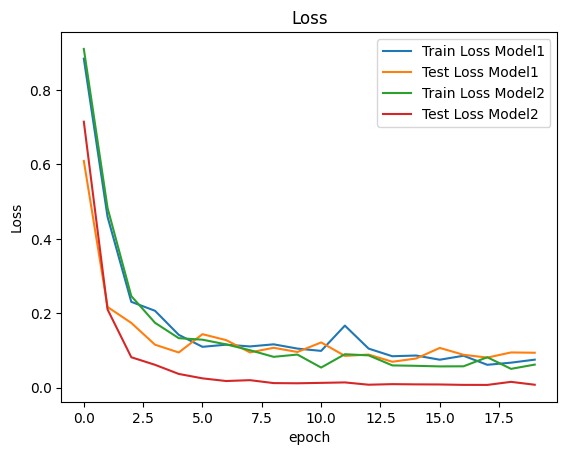

In [ ]:
#plot of accuracies of the models
plt.plot(model1_log['loss'],label='Train Loss Model1')
plt.plot(model1_log['test_loss'],label='Test Loss Model1')
plt.plot(model2_log['loss'],label='Train Loss Model2')
plt.plot(model2_log['test_loss'],label='Test Loss Model2')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()


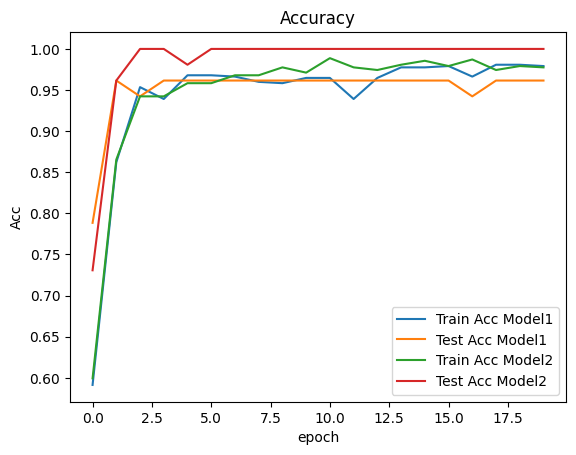

In [ ]:
#plot of accuracies of the models
plt.plot(model1_log['acc'],label='Train Acc Model1')
plt.plot(model1_log['test_acc'],label='Test Acc Model1')
plt.plot(model2_log['acc'],label='Train Acc Model2')
plt.plot(model2_log['test_acc'],label='Test Acc Model2')
plt.xlabel('epoch')
plt.ylabel('Acc')
plt.title('Accuracy')
plt.legend()
plt.show()
